# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/charlottesville-va/mca?lat=37.9245&lon=-78.3957&search_distance=108#search=2~gallery~0'  # The page we want to scrape # I zoomed out because there were not enough just in cville but this is for motorcycles
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [3]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want
print(listings[0].prettify()) #see what classes listing have, found for any page they ALL had title, price, details, and a location

<li class="cl-static-search-result" title="2013 Harley Davidson Road Glide">
 <a href="https://washingtondc.craigslist.org/nva/mcy/d/burke-2013-harley-davidson-road-glide/7912488239.html">
  <div class="title">
   2013 Harley Davidson Road Glide
  </div>
  <div class="details">
   <div class="price">
    $13,000
   </div>
   <div class="location">
    Fairfax
   </div>
  </div>
 </a>
</li>



Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [4]:
import re
import numpy as np

# Motorcycle brands that are common and may be in the title of the listing that way I can try to use the brand to explain trends
brands = ['harley', 'davidson', 'honda', 'yamaha', 'kawasaki', 'suzuki', 'ducati',
          'bmw', 'triumph', 'ktm', 'indian', 'victory', 'aprilia', 'husqvarna']

data = []  # We'll save our listings in this object

for k in range(len(listings)):
    # Find elements first (aka title and price and LINK --> the THREE I am using!). The link is just to put in the data list ntot for like analysis
    title_elem = listings[k].find('div', class_='title')
    price_elem = listings[k].find('div', class_='price')
    link_elem = listings[k].find(href=True)

    # Skip if missing required fields
    if not title_elem or not price_elem or not link_elem: #prevents error if one of the listing is written completely so then we just skip that one
        continue

    title = title_elem.get_text().lower() #ALL lower case bc python case sensitive
    price = price_elem.get_text()
    link = link_elem['href'] #extracts actual URL not just html object

    # Get brand and year from the title string:
    words = title.split() #split up words than can look for specific words in there
    hits = [word for word in words if word in brands]  # Find brands in the title new_list = [what_to_add for loop_variable in original_list if condition]
    if len(hits) == 0: #label as missing if there is no brand of motorcycle in the title!
        brand = 'missing'
    else:
        brand = hits[0]

    # Get year from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title)  # Find year references in title (same way that done for cars!)
    if regex_search is None:  # If no hits, record year as missing value
        year = np.nan
    else:  # If hits, record year as first match
        year = regex_search.group(0)

    data.append({'title': title, 'price': price, 'year': year, 'brand': brand, 'link': link}) #append all this data to the empty list we made


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [17]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)

# Clean price variable, get rid of the dollar sign and comma that way I can actually compare the #s
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'], errors='coerce')



print(df.shape)
df.to_csv('./craigslist_cville_motorcycles.csv')  # Save data
df.head()

(92, 5)


,title,price,year,brand,link
0,2013 harley davidson road glide,13000,2013,harley,https://washingtondc.craigslist.org/nva/mcy/d/...
1,1981 yamaha xs650,3400,1981,yamaha,https://martinsburg.craigslist.org/mcy/d/marti...
2,1978 yamaha xs650 survivor beauty,3900,1978,yamaha,https://martinsburg.craigslist.org/mcy/d/marti...
3,bmw s1000xr sport touring motorcycle,8500,NaN,bmw,https://roanoke.craigslist.org/mcy/d/roanoke-b...
4,2013 harley davidson electra glide classic,8000,2013,harley,https://frederick.craigslist.org/mcy/d/brunswi...


With the data in and wrangled, we can now do some analysis:

count       92.000000
mean      5986.076087
std       4740.719390
min          0.000000
25%       2475.000000
50%       5500.000000
75%       7825.000000
max      22500.000000
Name: price, dtype: float64


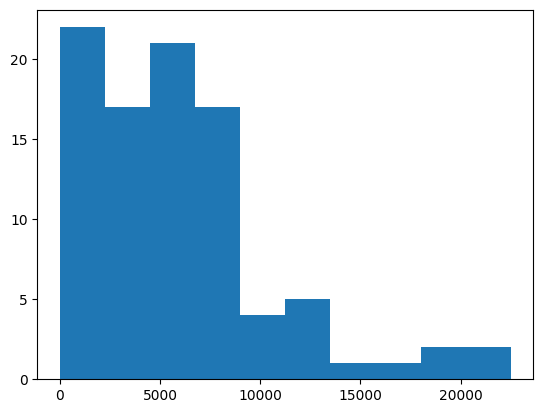

In [6]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()


I created this histogram to visualize the price spread for the motorcycles. It can be seen that the majority of motorcycles are between 0-10,000 dollars with the most being on the lower end of that range. There are very few that exceed 10,000 with the most expensive listed at 20,000. This shows visually the general price of motorcycles. I was next wondering if there was a specific brand that had the very expensive motorcycles or if they may just be random listings that are more expensive. how does this sound

In [7]:
# Price by brand:
df.loc[:,['price','year']].groupby('year').describe()
# Check how many listings have years
print(f"Total listings: {len(df)}") #see how many actual listings were scraped
print(f"Listings with years: {df['year'].notna().sum()}") #see how many of them the code identified a year
print(f"Listings with brands: {(df['brand'] != 'missing').sum()}") #see how many of them the code identified a brand
#this is helpeful because it allows me to see how many listing are missing data and if it was a large majority of them I would probably have altered my approach.

Total listings: 92
Listings with years: 70
Listings with brands: 68


In [8]:
# Age by brand:
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df.loc[:,['price','brand']].groupby('brand').describe() #grouping by brand because I wanted to see how the prand effects pricing

price                                                        \
         count          mean          std      min      25%      50%   
brand                                                                  
bmw        6.0   4420.166667  3196.524514     22.0   2350.0   4500.0   
ducati     2.0  17400.000000  3394.112550  15000.0  16200.0  17400.0   
harley    22.0   8760.636364  4831.997699   3500.0   6000.0   6800.0   
honda     11.0   4913.636364  5861.488331   1500.0   2250.0   2950.0   
indian     2.0   6500.000000  1414.213562   5500.0   6000.0   6500.0   
kawasaki  10.0   7230.000000  4040.640763   1000.0   3875.0   7700.0   
missing   24.0   3907.875000  3526.736160    300.0   1062.5   2347.5   
suzuki     4.0   3912.500000  3301.104613    650.0   1287.5   4000.0   
triumph    2.0   7500.000000  1414.213562   6500.0   7000.0   7500.0   
yamaha     9.0   3652.777778  1976.757305      0.0   3400.0   4000.0   

                             
               75%      max  
brand                        
bmw        6649.25   8500.0  
ducati    18600.00  19800.0  
harley     8749.25  22500.0  
honda      3550.00  21500.0  
indian     7000.00   7500.0  
kawasaki  11000.00  12000.0  
missing    6575.00  12000.0  
suzuki     6625.00   7000.0  
triumph    8000.00   8500.0  
yamaha     4200.00   6500.0

This table gives a nice representation of price information for different brands of motorcyle. The ducati motorcycles are the most expensive (there are only two) HOWEVER they are the most expensive by an order of magnitude of 10x. This answers one of the questions I had asked prior about the two abnormally expensive motorcycles in the histogram that were ~$20,000. This shows that those two motorcyles were both of the ducati brand and these motorcyles are likely very nice and expensive. Yamaha are the cheapest motorcyles and of the listings harley davidson motorcyles are the most common. I wanted to visualize each data point next in order to see if that would provide me with more correlation or information by also now integrating year as a variable. SO next I created a sccater plot.

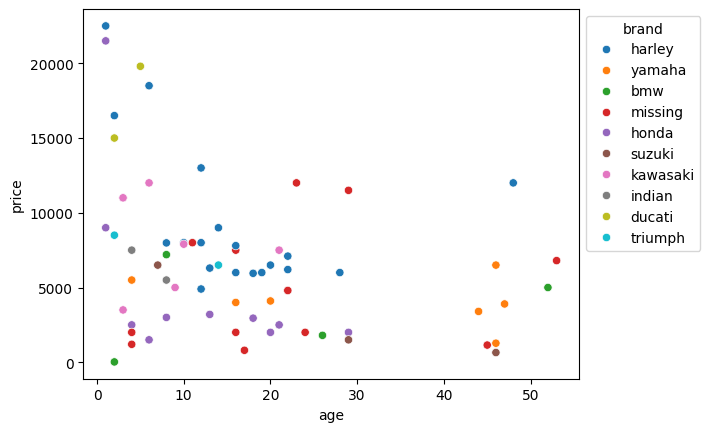

In [18]:
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df['age'] = 2025 - df['year']
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand') #scatter plot of year and price and then the color of each point corresponds with a different brand
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

This scatter plot is meant to show information and correlation regarding the information I scraped from each motorcycle object on Craig's list. I took the motorcyles brand and year from the title and then their price from the listing.

While there is not an apparent correlation between year of the motorcle and price of the motorcyle, it does seeem that older motorcyles (1980 or older) do not exceed ~$12500 whereas motorcyles 1995 or newer display a larger range of prices especially motorcyles from.

There is also a weird gap between 1980 and 1995 when there are no motorcycles being sold from that time period.

There is also not a lot of grouping of motorcyles by brand. The brand with the most consistent price over the different years being sold is lilkely the honda motorcyles (purple) that tend to all stay around the same price ~2500 with only 2 being much higher priced.

Next I would like to see if there is a way to better spread this data so I can extract trends. I am going to try a log-log scale to do this.

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


           log_price   log_age
log_price   1.179865 -0.214540
log_age    -0.214540  1.066882
           log_price   log_age
log_price   1.000000 -0.201574
log_age    -0.201574  1.000000


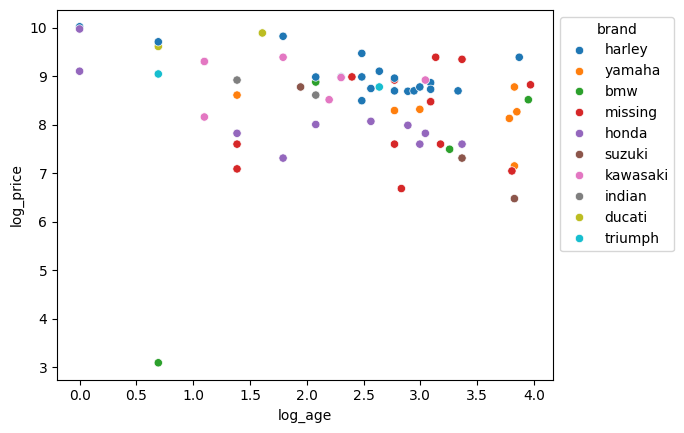

In [19]:
#change to log scale to visualze better
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])
ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

The next graph here is on a log-log scale to see if I can better extract trends. After this it now seems that all the data is just clustered along the top. There is not really any specific trends to extract.
With more data, I would try the following to find clearer patterns:

- scrape an even larger area to increase sample size to >100, as I currently only have a limited number of motorcycles with complete year information
- extract additional variables like mileage or condition from the titles to see if these better explain price variation; compare prices across different motorcycle types (cruiser, sport bike, dirt bike) rather than just brands because these may be a better indicator of pricing variation.
- look at location data to see if certain areas have higher-priced listings or filter outliers or focus on specific year ranges where I have more data points.

The limited trends may also reflect the reality of the local Craigslist market, used motorcycles have high price variability due to factors like condition, modifications, and seller motivation that aren't captured in basic listings data and every independent seller may have different opinions on what is a reasonable listing price. Some may price it low just because they want to get rid of it while others may be trying to actually make money and price it higher.

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.